In [55]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose
!pip install stardist


In [56]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

zsh:1: command not found: nvcc
zsh:1: command not found: nvidia-smi
>>> GPU activated? NO


***We will evaluate the perfromance of our cellpose model with one of the MIP images we manually segmented (mip_2.tif)***

In [101]:
from cellpose import io
# our mip image is here
dir = "cellposetraining/control/images"
files = io.get_image_files(dir, '')
print(files)
images = [io.imread(f) for f in files]
# our masks for our mip image are here
maskdir = "cellposetraining/control/masks"
gtfiles = io.get_image_files(maskdir, '')
print(gtfiles)
gt = [io.imread(m) for m in gtfiles]

#here is where we load the final model 
model_path = "cellposetraining/traindataHIL_mip/models/CP_mip_final"

model = models.CellposeModel(gpu=use_GPU, pretrained_model=model_path)
#running model evaluation on our images
masks, flows, styles = model.eval(images, channels = [0,0])



['cellposetraining/control/images/mip_2.tif']
['cellposetraining/control/masks/mip_2_labeled_grad.tif']


***Run cell below to see total number of cells detected***

In [102]:
print(np.max(masks))


1618


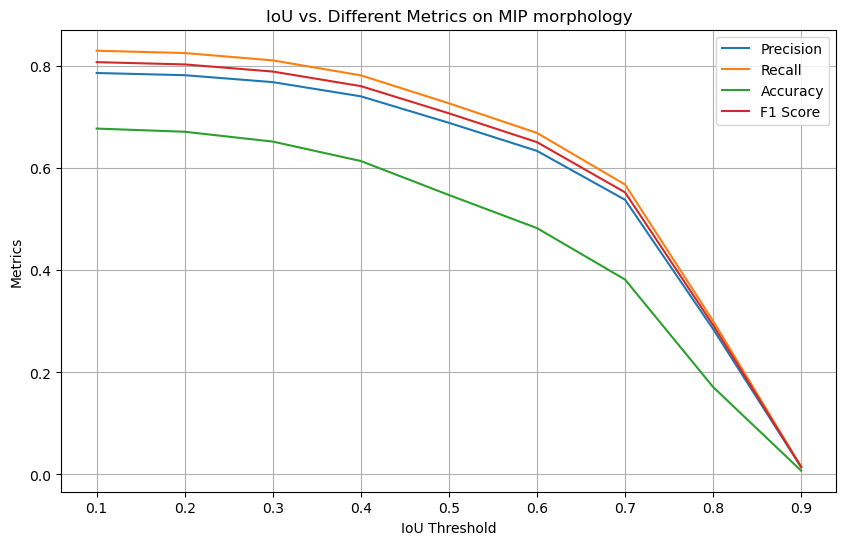

In [103]:
#We are using stardist's matching function to evaluate our model's perfromance 
from stardist.matching import matching
from tqdm import tqdm

# Define a range of IoU threshold values (you can adjust this range)
iou_thresholds = np.linspace(0.1, 0.9, num=9)

# Initialize lists to store metric values
precision_values = []
recall_values = []
accuracy_values = []
f1_values = []

# Calculate metrics for different IoU thresholds
for thresh in iou_thresholds:
    stats = matching(gt[0].astype(int), masks[0].astype(int), thresh=thresh)
    precision_values.append(stats.precision)
    recall_values.append(stats.recall)
    accuracy_values.append(stats.accuracy)
    f1_values.append(stats.f1)

# Plot IoU vs. Different Metrics
plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, precision_values, label='Precision')
plt.plot(iou_thresholds, recall_values, label='Recall')
plt.plot(iou_thresholds, accuracy_values, label='Accuracy')
plt.plot(iou_thresholds, f1_values, label='F1 Score')

plt.xlabel('IoU Threshold')
plt.ylabel('Metrics')
plt.title('IoU vs. Different Metrics on MIP morphology')
plt.legend()
plt.grid()
plt.show()


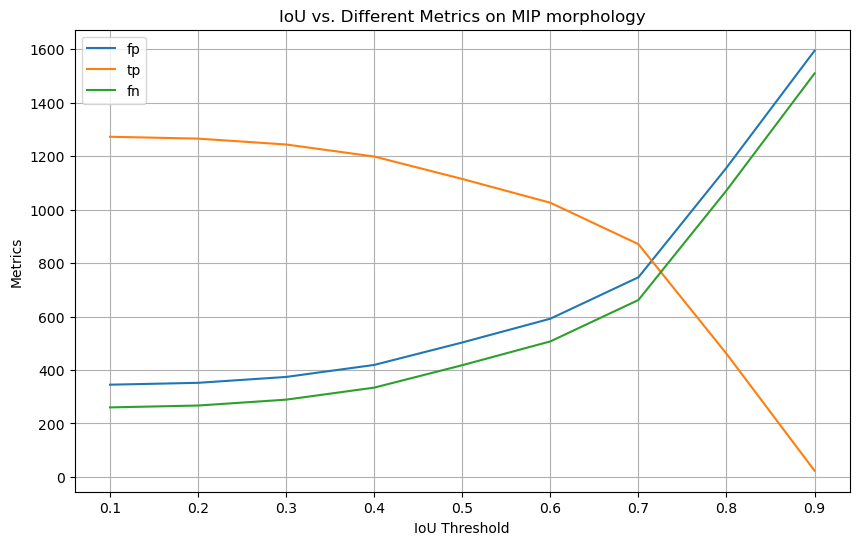

In [104]:
# Define a range of IoU threshold values (you can adjust this range)
iou_thresholds = np.linspace(0.1, 0.9, num=9)

# Initialize lists to store metric values
fp = []
tp = []
fn = []

# Calculate metrics for different IoU thresholds
for thresh in iou_thresholds:
    stats = matching(gt[0].astype(int), masks[0].astype(int), thresh=thresh)
    fp.append(stats.fp)
    tp.append(stats.tp)
    fn.append(stats.fn)

# Plot IoU vs. Different Metrics
plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, fp, label='fp')
plt.plot(iou_thresholds, tp, label='tp')
plt.plot(iou_thresholds, fn, label='fn')

plt.xlabel('IoU Threshold')
plt.ylabel('Metrics')
plt.title('IoU vs. Different Metrics on MIP morphology')
plt.legend()
plt.grid()
plt.show()

Extra utilities to save the results in the next two cells

In [109]:
#this saves the predicted masks into _seg.npy files
diameter = model.diam_labels
io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      diameter*np.ones(len(masks)),
                      files,
                      [0, 0])

In [ ]:
#You can also save masks as png, and tif
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[0, 0],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=False, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs
              )

Display Cellpose's segmentation outputs: Outlines, Predicted Masks and Flows


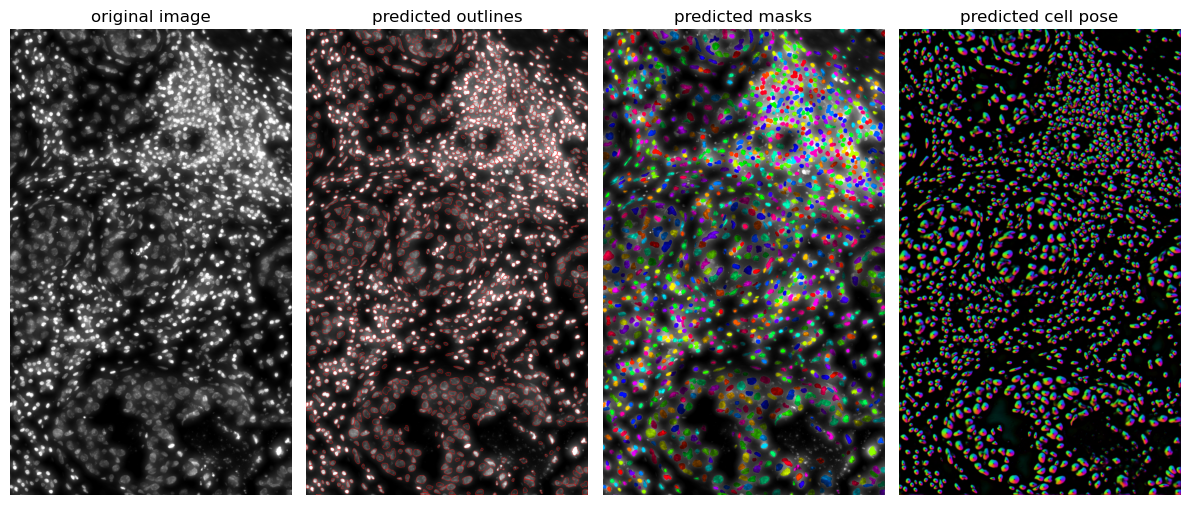

In [105]:
from cellpose import plot

nimg = len(images)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, images[idx], maski, flowi)
    plt.tight_layout()
    plt.show()